# Hotel Rate Regression Modeling

---

**Rate Regression for Forecasting**

In addition to predicting/forecasting reservation cancellations, hotels rely heavily on forecasting rates and occupancy.

Using the ADR (*Average Daily Rate*) feature from the dataset, I will train predictive models that could be used to forecast future ADR based on the given features.

The end result will be one (or more) models that would use specific features known *a priori* as the exogenous features to predict the ADR in dollars. After training the models, I will review their performances; determine which models are most appropriate (based on use cases and stakeholders); then provide three recommendations to help maximize ADR.

I will start with linear regression models to obtain the coefficients for ease-of-interpretation. Additionally, I will test a few tree-based models to compare performance; however, their results will require more effort to interpret for actionable insights.

---

In [1]:
## Used to upload 
%load_ext autoreload
%autoreload 2

In [2]:
## Data Handling
import pandas as pd
import numpy as np

import holidays

## Visualizations
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

## Custom-made Functions
from src import eda

In [3]:
## Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
pd.set_option('display.max_rows', 50)
%matplotlib inline

In [4]:
## SKLearn and Modeling Tools

from sklearn import metrics
from sklearn import set_config
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

set_config(transform_output='pandas')

In [5]:
# data_path = './data/H1.csv'

# data1 = pd.read_csv(data_path)

data1 = pd.read_parquet('./data/Datasets_for_Arrival_Date/Feature_Engineering/H1_T_Date_Features.parquet')
data1['HotelNumber'] = 1
data1.head()

,IsCanceled,LeadTime,ArrivalDateWeekNumber,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,Arrival_Date,Departure_Date,Booking_Date,Booking_Date_DoW,Arrival_Date_DoW,Departure_Date_DoW,Booking_Date_DoY,Arrival_Date_DoY,Departure_Date_DoY,occupancy_at_arrival,occupancy_at_departure,occupancy_pct_at_arrival,occupancy_pct_at_departure,occupancy_pct_at_arrival_7d_avg,Dynamic_Pricing_Indicator,HotelNumber
0,0,342,27,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-07-01,2015-07-01,2014-07-24,4,3,3,205,182,182,41,41,11.52,11.52,11.52,0,1
1,0,127,27,2,0,0,HB,GBR,Offline TA/TO,TA/TO,0,0,0,D,I,0,No Deposit,115,NULL,0,Contract,94.95,0,1,Check-Out,2015-07-01,2015-07-01,2015-07-08,2015-02-24,2,3,3,55,182,189,41,201,11.52,56.46,11.52,0,1
2,0,78,27,2,0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,D,D,0,No Deposit,5,NULL,0,Transient,63.60,1,0,Check-Out,2015-07-08,2015-07-01,2015-07-08,2015-04-14,2,3,3,104,182,189,41,201,11.52,56.46,11.52,0,1
3,0,48,27,2,0,0,BB,IRL,Offline TA/TO,TA/TO,0,0,0,D,D,0,No Deposit,8,NULL,0,Contract,79.50,0,0,Check-Out,2015-07-08,2015-07-01,2015-07-08,2015-05-14,4,3,3,134,182,189,41,201,11.52,56.46,11.52,0,1
4,1,60,27,2,0,0,BB,PRT,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,240,NULL,0,Transient,107.00,0,2,Canceled,2015-05-11,2015-07-01,2015-07-08,2015-05-02,6,3,3,122,182,189,41,201,11.52,56.46,11.52,0,1


In [6]:
# data_path = './data/H2.csv'

# data2 = pd.read_csv(data_path)
# data2['HotelNumber'] = 2
# data2.head()


data2 = pd.read_parquet('./data/Datasets_for_Arrival_Date/Feature_Engineering/H2_T_Date_Features.parquet')
data2['HotelNumber'] = 2
data2.head()

,IsCanceled,LeadTime,ArrivalDateWeekNumber,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,Arrival_Date,Departure_Date,Booking_Date,Booking_Date_DoW,Arrival_Date_DoW,Departure_Date_DoW,Booking_Date_DoY,Arrival_Date_DoY,Departure_Date_DoY,occupancy_at_arrival,occupancy_at_departure,occupancy_pct_at_arrival,occupancy_pct_at_departure,occupancy_pct_at_arrival_7d_avg,Dynamic_Pricing_Indicator,HotelNumber
0,0,6,27,1,0.00,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-03,2015-07-01,2015-07-03,2015-06-25,4,3,5,176,182,184,79,71,13.01,11.70,13.01,0,2
1,0,257,27,2,0.00,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6,NULL,0,Transient,101.50,0,0,Check-Out,2015-07-03,2015-07-01,2015-07-03,2014-10-17,5,3,5,290,182,184,79,71,13.01,11.70,13.01,0,2
2,0,257,27,2,0.00,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6,NULL,0,Transient,101.50,0,0,Check-Out,2015-07-03,2015-07-01,2015-07-03,2014-10-17,5,3,5,290,182,184,79,71,13.01,11.70,13.01,0,2
3,0,257,27,2,0.00,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6,NULL,0,Transient,101.50,0,0,Check-Out,2015-07-03,2015-07-01,2015-07-03,2014-10-17,5,3,5,290,182,184,79,71,13.01,11.70,13.01,0,2
4,0,257,27,2,0.00,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6,NULL,0,Transient,101.50,0,0,Check-Out,2015-07-03,2015-07-01,2015-07-03,2014-10-17,5,3,5,290,182,184,79,71,13.01,11.70,13.01,0,2


In [7]:
df_data = pd.concat([data1, data2], axis = 0).reset_index(drop=True)
df_data.head()

,IsCanceled,LeadTime,ArrivalDateWeekNumber,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,Arrival_Date,Departure_Date,Booking_Date,Booking_Date_DoW,Arrival_Date_DoW,Departure_Date_DoW,Booking_Date_DoY,Arrival_Date_DoY,Departure_Date_DoY,occupancy_at_arrival,occupancy_at_departure,occupancy_pct_at_arrival,occupancy_pct_at_departure,occupancy_pct_at_arrival_7d_avg,Dynamic_Pricing_Indicator,HotelNumber
0,0,342,27,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-07-01,2015-07-01,2014-07-24,4,3,3,205,182,182,41,41,11.52,11.52,11.52,0,1
1,0,127,27,2,0.00,0,HB,GBR,Offline TA/TO,TA/TO,0,0,0,D,I,0,No Deposit,115,NULL,0,Contract,94.95,0,1,Check-Out,2015-07-01,2015-07-01,2015-07-08,2015-02-24,2,3,3,55,182,189,41,201,11.52,56.46,11.52,0,1
2,0,78,27,2,0.00,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,D,D,0,No Deposit,5,NULL,0,Transient,63.60,1,0,Check-Out,2015-07-08,2015-07-01,2015-07-08,2015-04-14,2,3,3,104,182,189,41,201,11.52,56.46,11.52,0,1
3,0,48,27,2,0.00,0,BB,IRL,Offline TA/TO,TA/TO,0,0,0,D,D,0,No Deposit,8,NULL,0,Contract,79.50,0,0,Check-Out,2015-07-08,2015-07-01,2015-07-08,2015-05-14,4,3,3,134,182,189,41,201,11.52,56.46,11.52,0,1
4,1,60,27,2,0.00,0,BB,PRT,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,240,NULL,0,Transient,107.00,0,2,Canceled,2015-05-11,2015-07-01,2015-07-08,2015-05-02,6,3,3,122,182,189,41,201,11.52,56.46,11.52,0,1


In [8]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107451 entries, 0 to 107450
Data columns (total 42 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   IsCanceled                       107451 non-null  int64         
 1   LeadTime                         107451 non-null  int64         
 2   ArrivalDateWeekNumber            107451 non-null  int64         
 3   Adults                           107451 non-null  int64         
 4   Children                         107447 non-null  float64       
 5   Babies                           107451 non-null  int64         
 6   Meal                             107451 non-null  object        
 7   Country                          106963 non-null  object        
 8   MarketSegment                    107451 non-null  object        
 9   DistributionChannel              107451 non-null  object        
 10  IsRepeatedGuest                  107451 non-

# Location, Location, Location!

---

**Additional Data About Locations and Types**

Two details that impact pricing significantly would be location - rural vs. urban - and the hotel rating (e.g., select service vs. premium vs. luxury). The original dataset does not include these specific details, but the authors specify such details in the source article. The authors of the academic paper from which I sourced this data specify the following details about the hotels:

> *Both hotels are located in Portugal: H1 at the resort region of Algarve and H2 at the city of Lisbon.*

Modeling each hotel separately is similar to a real-life revenue forecasting scenario - when predicting/setting rates, hotel managers consider each hotel separately. Two models will create slightly more work, but I expect this approach will improve the model performances.

Using this additional information, I can perform additional feature engineering based on their location and other historical data, such as weather, temperatures, etc.. Furthermore, I could use the locations as a new feature and concatenate the datasets for an overall interpretation.

---

## Regression: Hotel 1

---

I will start with the first of the two separate hotel datasets.

This hotel is located in Algarve, Portugal, and as the location is described as a *"resort region,"* I will assume it is a resort-style hotel.



---

In [9]:
data1.head()

,IsCanceled,LeadTime,ArrivalDateWeekNumber,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,Arrival_Date,Departure_Date,Booking_Date,Booking_Date_DoW,Arrival_Date_DoW,Departure_Date_DoW,Booking_Date_DoY,Arrival_Date_DoY,Departure_Date_DoY,occupancy_at_arrival,occupancy_at_departure,occupancy_pct_at_arrival,occupancy_pct_at_departure,occupancy_pct_at_arrival_7d_avg,Dynamic_Pricing_Indicator,HotelNumber
0,0,342,27,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-07-01,2015-07-01,2014-07-24,4,3,3,205,182,182,41,41,11.52,11.52,11.52,0,1
1,0,127,27,2,0,0,HB,GBR,Offline TA/TO,TA/TO,0,0,0,D,I,0,No Deposit,115,NULL,0,Contract,94.95,0,1,Check-Out,2015-07-01,2015-07-01,2015-07-08,2015-02-24,2,3,3,55,182,189,41,201,11.52,56.46,11.52,0,1
2,0,78,27,2,0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,D,D,0,No Deposit,5,NULL,0,Transient,63.60,1,0,Check-Out,2015-07-08,2015-07-01,2015-07-08,2015-04-14,2,3,3,104,182,189,41,201,11.52,56.46,11.52,0,1
3,0,48,27,2,0,0,BB,IRL,Offline TA/TO,TA/TO,0,0,0,D,D,0,No Deposit,8,NULL,0,Contract,79.50,0,0,Check-Out,2015-07-08,2015-07-01,2015-07-08,2015-05-14,4,3,3,134,182,189,41,201,11.52,56.46,11.52,0,1
4,1,60,27,2,0,0,BB,PRT,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,240,NULL,0,Transient,107.00,0,2,Canceled,2015-05-11,2015-07-01,2015-07-08,2015-05-02,6,3,3,122,182,189,41,201,11.52,56.46,11.52,0,1


In [10]:
# ## Keeping zero-dollar ADR just in case it's useful
# data1 = data1[data1['ADR'] > 0]
# data1

In [11]:
drop_cols = ['IsCanceled', 'ReservationStatus', 'ReservationStatusDate', 'HotelNumber']
data1 = data1.drop(columns = drop_cols).reset_index(drop=True)
data1

,LeadTime,ArrivalDateWeekNumber,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,Arrival_Date,Departure_Date,Booking_Date,Booking_Date_DoW,Arrival_Date_DoW,Departure_Date_DoW,Booking_Date_DoY,Arrival_Date_DoY,Departure_Date_DoY,occupancy_at_arrival,occupancy_at_departure,occupancy_pct_at_arrival,occupancy_pct_at_departure,occupancy_pct_at_arrival_7d_avg,Dynamic_Pricing_Indicator
0,342,27,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NULL,NULL,0,Transient,0.00,0,0,2015-07-01,2015-07-01,2014-07-24,4,3,3,205,182,182,41,41,11.52,11.52,11.52,0
1,127,27,2,0,0,HB,GBR,Offline TA/TO,TA/TO,0,0,0,D,I,0,No Deposit,115,NULL,0,Contract,94.95,0,1,2015-07-01,2015-07-08,2015-02-24,2,3,3,55,182,189,41,201,11.52,56.46,11.52,0
2,78,27,2,0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,D,D,0,No Deposit,5,NULL,0,Transient,63.60,1,0,2015-07-01,2015-07-08,2015-04-14,2,3,3,104,182,189,41,201,11.52,56.46,11.52,0
3,48,27,2,0,0,BB,IRL,Offline TA/TO,TA/TO,0,0,0,D,D,0,No Deposit,8,NULL,0,Contract,79.50,0,0,2015-07-01,2015-07-08,2015-05-14,4,3,3,134,182,189,41,201,11.52,56.46,11.52,0
4,60,27,2,0,0,BB,PRT,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,240,NULL,0,Transient,107.00,0,2,2015-07-01,2015-07-08,2015-05-02,6,3,3,122,182,189,41,201,11.52,56.46,11.52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36049,240,25,2,1,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,315,NULL,0,Contract,102.38,0,1,2017-06-22,2017-06-29,2016-10-25,2,4,4,299,173,180,281,36,78.93,10.11,78.93,1
36050,0,25,2,0,0,BB,PRT,Complementary,Direct,1,0,1,G,G,0,No Deposit,NULL,NULL,0,Transient,0.00,0,2,2017-06-22,2017-06-23,2017-06-22,4,4,5,173,173,174,281,233,78.93,65.45,78.93,1
36051,324,25,2,0,0,BB,IRL,Online TA,TA/TO,0,0,0,D,D,1,No Deposit,240,NULL,0,Transient,89.98,0,1,2017-06-22,2017-07-01,2016-08-02,2,4,6,215,173,182,281,19,78.93,5.34,78.93,1
36052,226,25,2,0,0,HB,DEU,Online TA,TA/TO,0,0,0,E,E,1,No Deposit,314,NULL,0,Transient,128.00,0,0,2017-06-22,2017-07-02,2016-11-08,2,4,7,313,173,183,281,15,78.93,4.21,78.93,0


In [12]:
data1['ADR'].describe()

count   36,054.00
mean        84.94
std         52.54
min         -6.38
25%         48.00
50%         70.00
75%        107.00
max        508.00
Name: ADR, dtype: float64

# Drop Negative ADR Values

I need to perform a logarithmic transformation on the target feature to help normalize the feature. In order to do so, I need to ensure that all of my target values are greater than or equal to zero.

In [13]:
data1['ADR'].describe()

count   36,054.00
mean        84.94
std         52.54
min         -6.38
25%         48.00
50%         70.00
75%        107.00
max        508.00
Name: ADR, dtype: float64

In [14]:
data1 = data1[data1['ADR'] > 0].reset_index(drop=True)
data1

,LeadTime,ArrivalDateWeekNumber,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,Arrival_Date,Departure_Date,Booking_Date,Booking_Date_DoW,Arrival_Date_DoW,Departure_Date_DoW,Booking_Date_DoY,Arrival_Date_DoY,Departure_Date_DoY,occupancy_at_arrival,occupancy_at_departure,occupancy_pct_at_arrival,occupancy_pct_at_departure,occupancy_pct_at_arrival_7d_avg,Dynamic_Pricing_Indicator
0,127,27,2,0,0,HB,GBR,Offline TA/TO,TA/TO,0,0,0,D,I,0,No Deposit,115,NULL,0,Contract,94.95,0,1,2015-07-01,2015-07-08,2015-02-24,2,3,3,55,182,189,41,201,11.52,56.46,11.52,0
1,78,27,2,0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,D,D,0,No Deposit,5,NULL,0,Transient,63.60,1,0,2015-07-01,2015-07-08,2015-04-14,2,3,3,104,182,189,41,201,11.52,56.46,11.52,0
2,48,27,2,0,0,BB,IRL,Offline TA/TO,TA/TO,0,0,0,D,D,0,No Deposit,8,NULL,0,Contract,79.50,0,0,2015-07-01,2015-07-08,2015-05-14,4,3,3,134,182,189,41,201,11.52,56.46,11.52,0
3,60,27,2,0,0,BB,PRT,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,240,NULL,0,Transient,107.00,0,2,2015-07-01,2015-07-08,2015-05-02,6,3,3,122,182,189,41,201,11.52,56.46,11.52,0
4,77,27,2,0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,94.00,0,0,2015-07-01,2015-07-08,2015-04-15,3,3,3,105,182,189,41,201,11.52,56.46,11.52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35330,240,25,2,0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,315,NULL,0,Contract,81.90,0,1,2017-06-22,2017-06-29,2016-10-25,2,4,4,299,173,180,281,36,78.93,10.11,78.93,1
35331,240,25,2,1,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,315,NULL,0,Contract,102.38,0,1,2017-06-22,2017-06-29,2016-10-25,2,4,4,299,173,180,281,36,78.93,10.11,78.93,1
35332,324,25,2,0,0,BB,IRL,Online TA,TA/TO,0,0,0,D,D,1,No Deposit,240,NULL,0,Transient,89.98,0,1,2017-06-22,2017-07-01,2016-08-02,2,4,6,215,173,182,281,19,78.93,5.34,78.93,1
35333,226,25,2,0,0,HB,DEU,Online TA,TA/TO,0,0,0,E,E,1,No Deposit,314,NULL,0,Transient,128.00,0,0,2017-06-22,2017-07-02,2016-11-08,2,4,7,313,173,183,281,15,78.93,4.21,78.93,0


In [15]:
data1['ADR'].describe()

count   35,335.00
mean        86.67
std         51.64
min          0.26
25%         49.21
50%         71.00
75%        108.00
max        508.00
Name: ADR, dtype: float64

# Outliers in Target Feature

In [16]:
# from scipy.stats import zscore

# z_scores = zscore(data1['ADR'])
# abs_z_scores = np.abs(z_scores)
# filtered_entries = (abs_z_scores < 3)  # Threshold of 3
# cleaned_data = data1[filtered_entries].reset_index(drop=True)
# cleaned_data

In [17]:
# data1[(abs_z_scores >= 3)]

# Train/Test Split

In [18]:
## Splitting data into features and target variables.
target = 'ADR'

X = data1.drop(columns = [target]).copy()
y = data1[target].copy()

In [19]:
## Splitting - stratify to maintain class balance b/t X_train/_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, 
                                                    random_state = 42)

# Inspecting Target Feature

In [20]:
y_train.describe()

count   26,501.00
mean        86.73
std         51.81
min          0.26
25%         49.16
50%         71.04
75%        108.00
max        508.00
Name: ADR, dtype: float64

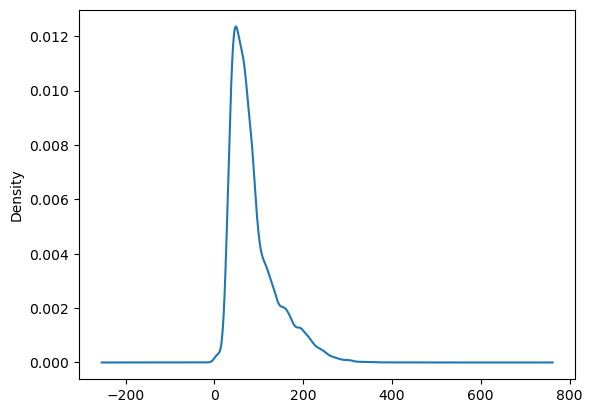

In [21]:
y_train.plot(kind ='kde');

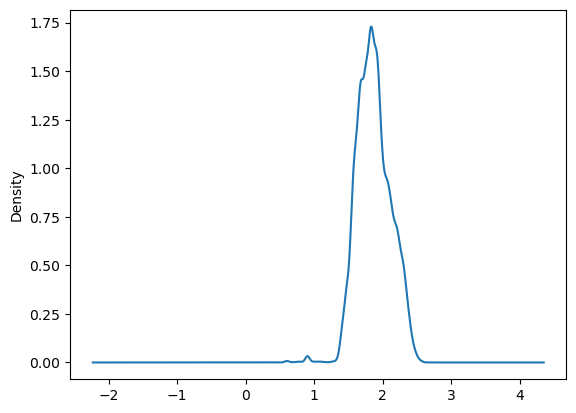

In [22]:
y_train.apply(np.log10).plot(kind = 'kde');

# Pipeline and Modeling

In [23]:
## Specifying numeric columns for preprocessing
num_cols = X_train.select_dtypes('number').columns.to_list()

## Specifying numeric columns for preprocessing
cat_cols = X_train.select_dtypes(include='object').columns.to_list()

In [24]:
## Creating ColumnTransformer and sub-transformers for imputation and encoding

### --- Creating column pipelines --- ###

cat_pipe = Pipeline(steps=[('cat_imputer', SimpleImputer(add_indicator=True,
                                                         strategy='most_frequent')),
                           ('ohe', OneHotEncoder(drop = 'if_binary',
                                                 handle_unknown='ignore',
                                                 sparse_output=False))])

num_pipe = Pipeline(steps=[('num_imputer', SimpleImputer(add_indicator=True,strategy='median')),
                          ('scaler',StandardScaler())])

### --- Instantiating the ColumnTransformer --- ###
preprocessor = ColumnTransformer(
    transformers=[('num', num_pipe, num_cols),
                  ('cat', cat_pipe, cat_cols)])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['LeadTime', 'ArrivalDateWeekNumber', 'Adults',
                                  'Children', 'Babies', 'IsRepeatedGuest',
                                  'PreviousCancellations',
                                  'PreviousBookingsNotCanceled',
                                  'BookingChanges', 'DaysInWaitingList',
                                  'RequiredCarParkingSpac...
                                  'Dynamic_Pricing_Indicator']),
                                ('cat',
                                 Pipeline(steps=[('cat_imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Meal', 'Country', 'MarketSegment',
                                  'DistributionChannel', 'ReservedRoomType',
                                  'AssignedRoomType', 'DepositType', 'Agent',
                                  'Company', 'CustomerType'])])

In [25]:
## Transform via the ColumnTransformer preprocessor and create new dataframe

preprocessor.fit(X_train)

X_train_df = preprocessor.transform(X_train)

X_test_tf_df = preprocessor.transform(X_test)

# display(X_train_df.head(5),X_test_tf_df.head(5))

C:\Users\Ben\anaconda3\envs\dojo-env\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1, 7, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [28]:
hgbr = HistGradientBoostingRegressor(l2_regularization = .01, random_state=42)
hgbr.fit(X_train_df, y_train)

# ttr_hgbr = TransformedTargetRegressor(hgbr, func=np.log, inverse_func=np.exp)
# ttr_hgbr.fit(X_train_df, y_train)

HistGradientBoostingRegressor(l2_regularization=0.01, random_state=42)

In [29]:
train_scores = cross_val_score(hgbr, X_train_df, y_train, cv=5, n_jobs=-1)
test_scores = cross_val_score(hgbr, X_test_tf_df, y_test, cv=5, n_jobs=-1)


print(f'The training score is: {round(train_scores.mean(), 2)}.\nThe test score is: {round(test_scores.mean(), 2)}.')

The training score is: 0.92.
The test score is: 0.91.


In [31]:
y_pred = hgbr.predict(X_test_tf_df)

mape = metrics.mean_absolute_percentage_error(y_test, y_pred).round(2)

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred)).round(2)

print(f'The MAPE score is: {mape}.\nThe RMSE is: {rmse}.')

The MAPE score is: 0.15.
The RMSE is: 14.2.


In [ ]:
# hgbc = TransformedTargetRegressor(regressor=HistGradientBoostingRegressor(random_state=42),
#                                 func=np.log, inverse_func=np.exp)
# hgbc.fit(X_train_df, y_train)

# print(f'The training score is: {hgbc.score(X = X_train_df, y = y_train):.4f}.',
#       f'\nThe test score is: {hgbc.score(X = X_test_tf_df, y = y_test):.4f}.')

In [ ]:
perm_imp = permutation_importance(ttr_hgbr, X_test_tf_df, y_test, scoring = 'r2', n_jobs = -1, random_state = 42)

# perm_imp_results = pd.Series(data = perm_imp.importances_mean, index = hgbr.feature_names_in_).sort_values(ascending = False)
perm_imp_results = pd.Series(data = perm_imp.importances_mean).sort_values(ascending = False)
perm_imp_results.head()

In [ ]:
rfr = RandomForestRegressor(n_jobs = -1, random_state = 42)

rfr.fit(X_train_df, y_train)

rfr.score(X = X_test_tf_df, y = y_test).round(4)

In [ ]:
# lr = LinearRegression()

# lr.fit(X_train_df, y_train)

# lr.score(X = X_test_tf_df, y = y_test).round(4)

In [ ]:
# rr = RANSACRegressor()

# rr.fit(X_train_df, y_train)

# rr.score(X = X_test_tf_df, y = y_test).round(4)